In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, r2_score
import sqlite3
from datetime import datetime
import matplotlib.dates as mdates


In [2]:
def requete_sql (requete) :
    try:
        connexion = sqlite3.connect('./data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

# Import des données
## Sélection des piezos
Exemple pour la région centre val de Loire.  
Récupération des codes_bss dans la liste des départements pour les fichiers dispos

In [81]:
region = "CVL"

requete = f"""
        SELECT code_bss
        FROM data_piezo
        WHERE code_dpt IN (18,28,36,37,41,45)
        AND fichier_piezo IS 1
         """
data = requete_sql(requete)
code_bss = []
for code in data:
    code_bss.append(code[0]) 

Connexion réussie à SQLite
Connexion SQLite est fermée


In [82]:
code_bss

['03296X1032_PC1',
 '03646X0086_F1',
 '05471X0070_P1',
 '05445X0081_P1',
 '03627X0052_P1',
 '05475X0057_P1',
 '04915X0009_F1AEP1',
 '05421X0001_FAEP1',
 '04286X0001_FAEP1',
 '04624X0002_FAEP1',
 '04265X0012_FAEP1',
 '05943X0006_FAEP1',
 '03282X0043_S1',
 '03287X0018_S1',
 '02896X0013_F2',
 '03646X0087_F2',
 '04606X0021_FAEP2',
 '04277X0062_FAEP2',
 '04911X0013_FAEP2',
 '04581X0015_FAEP2',
 '04892X0006_FAEP2',
 '04003X0018_FAEP2',
 '05707X0009_FAEP2',
 '03646X0105_F3',
 '05176X0033_FAEP3',
 '05933X0006_FAEP3',
 '03983X0267_PZ3',
 '04936X0010_F',
 '04602X0020_F',
 '03244X0020_F',
 '05695X0050_F',
 '03243X0001_F',
 '04302X0101_F',
 '04316X0061_F',
 '04891X0042_F',
 '02912X0082_F',
 '05432X0003_F',
 '04262X0003_F',
 '05726X0003_F',
 '04261X2003_F',
 '03254X0103_F',
 '04623X0053_F',
 '04593X0073_F',
 '04625X0073_F',
 '03963X0083_F',
 '03634X0093_F',
 '03997X0004_F',
 '04612X0024_F',
 '04326X0034_F',
 '04323X0005_F',
 '04563X0105_F',
 '05422X0015_F',
 '04938X0006_F',
 '04004X0007_F',
 '03618

## Construction d'un dataframe

In [83]:
directory = './data/piezo/'

# Lecture des données du premier piezo de la liste pour initialiser le dataframe
data = pd.read_csv(directory+f"{code_bss[0]}.csv", sep=";",  index_col=0, parse_dates=True)
data.rename(columns={"piezo":f"{code_bss[0]}"}, inplace=True)

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

for file in code_bss[1:]:
    df = pd.read_csv(f"{directory+file}.csv", sep=";",  index_col=0, parse_dates=True, date_parser=custom_date_parser)
    df.rename(columns={"piezo":f"{file}"}, inplace=True)
    data = pd.merge(data,df,left_index=True, right_index=True,how='outer')

In [84]:
data

03296X1032_PC1  03646X0086_F1  05471X0070_P1  05445X0081_P1  \
date_mesure                                                                
1965-10-13              NaN            NaN            NaN            NaN   
1965-10-14              NaN            NaN            NaN            NaN   
1965-10-18              NaN            NaN            NaN            NaN   
1965-10-20              NaN            NaN            NaN            NaN   
1965-10-21              NaN            NaN            NaN            NaN   
...                     ...            ...            ...            ...   
2022-05-26           -14.82         -31.56          -3.23         -13.35   
2022-05-27           -14.85         -31.78          -3.21         -13.33   
2022-05-28           -14.84         -32.08          -3.21         -13.32   
2022-05-29           -14.82         -31.96          -3.23         -13.31   
2022-05-30           -14.81         -31.95            NaN         -13.31   

             03627X0052_P1  05475X0057_P1  04915X0009_F1AEP1  \
date_mesure                                                    
1965-10-13             NaN            NaN                NaN   
1965-10-14             NaN            NaN                NaN   
1965-10-18             NaN            NaN                NaN   
1965-10-20             NaN            NaN                NaN   
1965-10-21             NaN            NaN                NaN   
...                    ...            ...                ...   
2022-05-26          -10.53          -0.88              -1.02   
2022-05-27          -10.53          -0.88              -1.02   
2022-05-28          -10.54          -0.89                NaN   
2022-05-29          -10.53          -0.98                NaN   
2022-05-30          -10.54          -1.15                NaN   

             05421X0001_FAEP1  04286X0001_FAEP1  04624X0002_FAEP1  ...  \
date_mesure                                                        ...   
1965-10-13                NaN               NaN               NaN  ...   
1965-10-14                NaN               NaN               NaN  ...   
1965-10-18                NaN               NaN               NaN  ...   
1965-10-20                NaN               NaN               NaN  ...   
1965-10-21                NaN               NaN               NaN  ...   
...                       ...               ...               ...  ...   
2022-05-26              -3.91               NaN               NaN  ...   
2022-05-27              -3.94               NaN               NaN  ...   
2022-05-28              -3.95               NaN               NaN  ...   
2022-05-29              -4.00               NaN               NaN  ...   
2022-05-30              -4.81               NaN               NaN  ...   

             03252X0011_S  03248X0015_S  05446X0136_S  05465X0001_PZ  \
date_mesure                                                            
1965-10-13            NaN           NaN           NaN            NaN   
1965-10-14            NaN           NaN           NaN            NaN   
1965-10-18            NaN           NaN           NaN            NaN   
1965-10-20            NaN           NaN           NaN            NaN   
1965-10-21            NaN           NaN           NaN            NaN   
...                   ...           ...           ...            ...   
2022-05-26          -4.05         -3.82         -7.76          -6.54   
2022-05-27          -4.42         -3.84         -7.77          -6.59   
2022-05-28          -4.49         -3.84           NaN          -6.62   
2022-05-29          -4.27         -3.84           NaN          -6.65   
2022-05-30          -4.69         -3.87           NaN          -6.68   

             04597X0065_PZ  03272X0006_PZ  04894X0016_PZ  03622X0027_PZ  \
date_mesure                                                               
1965-10-13             NaN         -25.73            NaN            NaN   
1965-10-14             NaN            NaN            NaN         -

## Visualisation des valeurs manquantes

In [85]:
# Fonction d'affichage des valeurs manquantes
def f_plot_nan (dataframe):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    sns.heatmap(dataframe.T.isna(), cmap='Blues', cbar=False)
    ax.set_title('Missing Values', fontsize=16)
    # Masquage des noms de piezo 
    ax.yaxis.set_visible(False)
    # Formatage de la date pour l'affichage
    ax.xaxis.set_ticklabels([pd.to_datetime(value).strftime('%Y') for value in ax.xaxis.get_major_formatter().func.args[0].values()])
    plt.show()

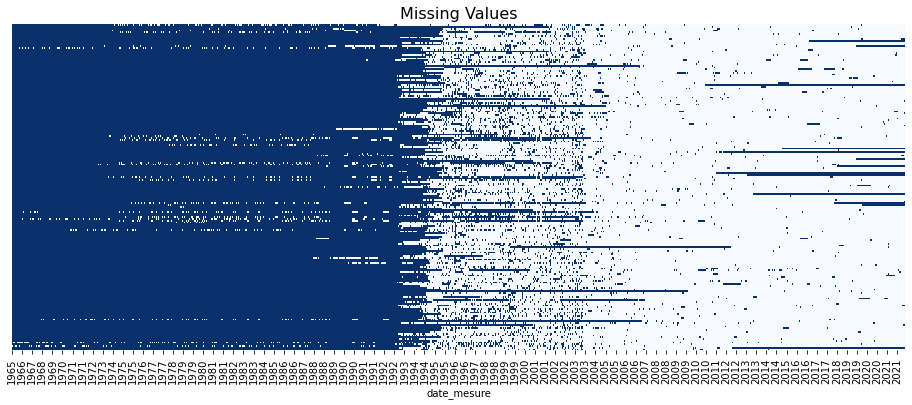

In [86]:
f_plot_nan(data)

# Traitement des données

## Rééchantillonnage à la semaine

In [87]:
data_week = pd.DataFrame(data.resample('7D').mean())

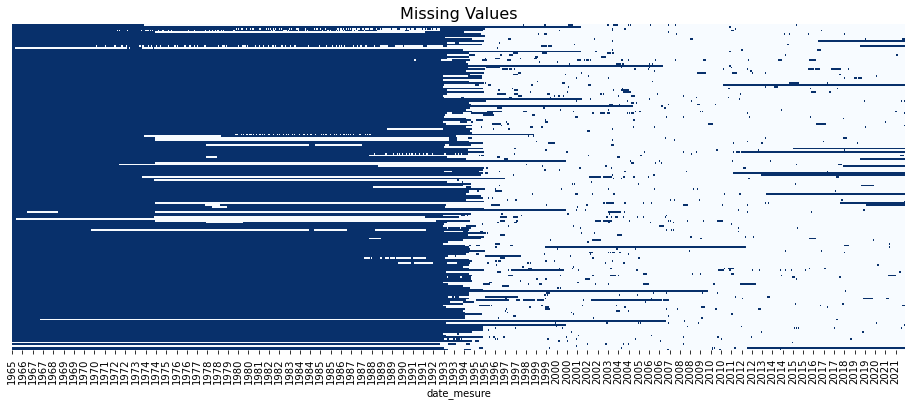

In [88]:
f_plot_nan(data_week)

In [89]:
data_week.shape

(2955, 185)

## Echelle de temps fixée après 1995 pour limiter les Nan

In [90]:
data_week_from_ = data_week.loc['01-01-1995':]

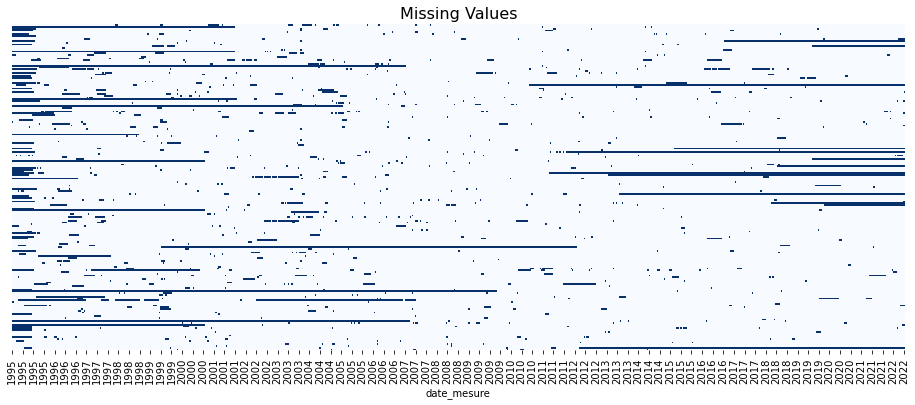

In [91]:
f_plot_nan(data_week_from_)

## Suppression des valeurs abbérantes
Utilisation de la méthode IQR pour supprimer les valeurs abbérantes.
- Calcul des quartiles et de l'écart interquartile
- Suppression des valeurs < Q1 - 1.5*IQR
- Suppression des valeurs > Q3 + 1.5*IQR

In [92]:
nbre_na = data_week_from_.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 16945 valeurs nulles dans l'ensemble du dataframe.


In [93]:
data_wo_outliers = data_week_from_.copy()

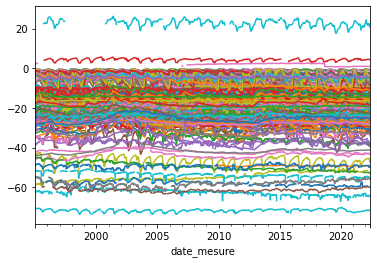

In [94]:
for piezo in data_wo_outliers.columns : 
    q1 = np.nanquantile(data_wo_outliers[f"{piezo}"], .25)
    q3 = np.nanquantile(data_wo_outliers[f"{piezo}"], .75)
    IQR = q3-q1
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] < (q1-1.5*IQR), piezo] = np.NaN
    data_wo_outliers.loc[data_wo_outliers[f"{piezo}"] > (q3+1.5*IQR), piezo] = np.NaN
    data_wo_outliers[f"{piezo}"].plot()

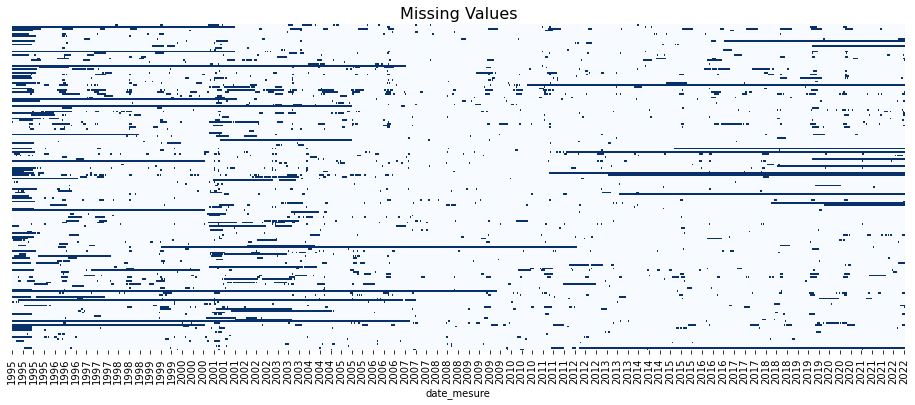

In [95]:
f_plot_nan(data_wo_outliers)

In [96]:
nbre_na_2 = data_wo_outliers.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_2} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 22479 valeurs nulles dans l'ensemble du dataframe.


## Suppression des piezos avec plus de 5% de valeurs manquantes

In [97]:
# Liste des piezos avec plus de 10% de valeurs manquantes
bss_to_drop = data.loc[:,data_wo_outliers.isna().sum()>0.05*data_wo_outliers.shape[0]].columns

In [98]:
data_clean = data_wo_outliers.copy().drop(bss_to_drop, axis=1)

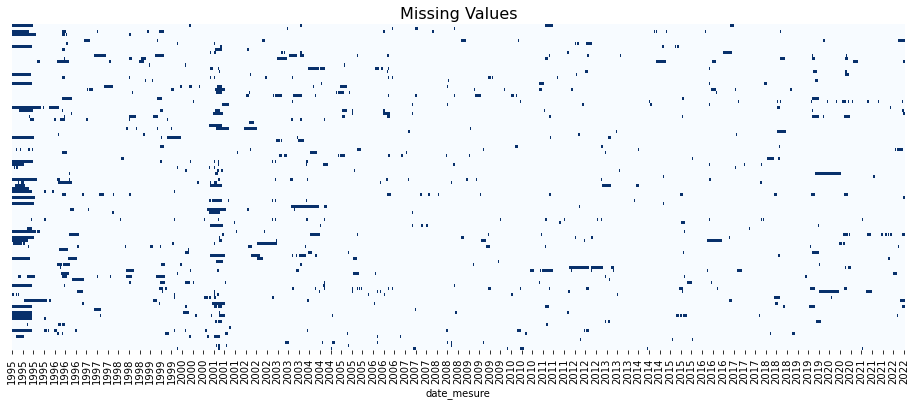

In [99]:
f_plot_nan(data_clean)

In [100]:
nbre_na_3 = data_clean.isna().sum().sum()
print(f"Il y a à ce stade {nbre_na_3} valeurs nulles dans l'ensemble du dataframe.")

Il y a à ce stade 3910 valeurs nulles dans l'ensemble du dataframe.


In [101]:
data_clean.shape

(1430, 108)

## Interpolation

In [102]:
data_interpol = data_clean.copy().interpolate('linear')

In [103]:
data_interpol.shape

(1430, 108)

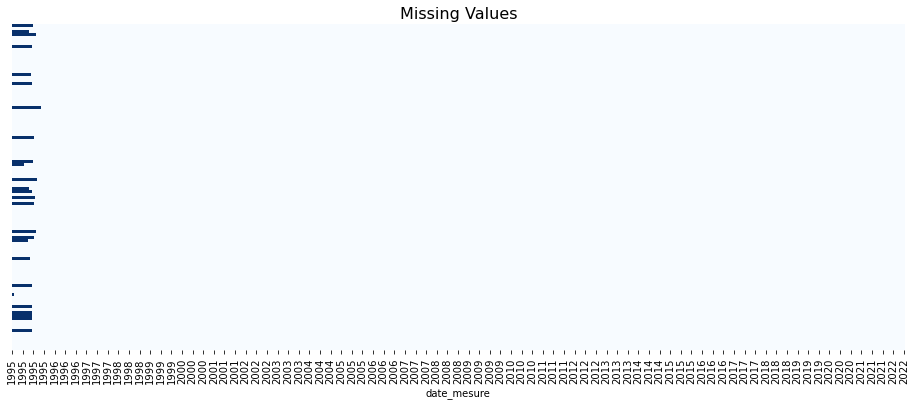

In [104]:
f_plot_nan(data_interpol)

## Réajustement des dates de début et de fin

In [105]:
debut = []
for column in data_interpol.columns:
    debut.append(data_interpol[f"{column}"].first_valid_index())
date_debut = max(debut)

In [106]:
fin = []
for column in data_interpol.columns:
    fin.append(data_interpol[f"{column}"].last_valid_index())
date_fin = min(fin)
date_fin

Timestamp('2022-05-25 00:00:00', freq='7D')

In [107]:
data_interpol = data_interpol.loc[date_debut:date_fin]

In [108]:
print(f"Nombre total de Nan : {data_interpol.isna().sum().sum()}")

Nombre total de Nan : 0


In [109]:
data_interpol.shape

(1383, 108)

In [110]:
data_interpol.shape[1]%4

0

## Affichage des chroniques après nettoyage

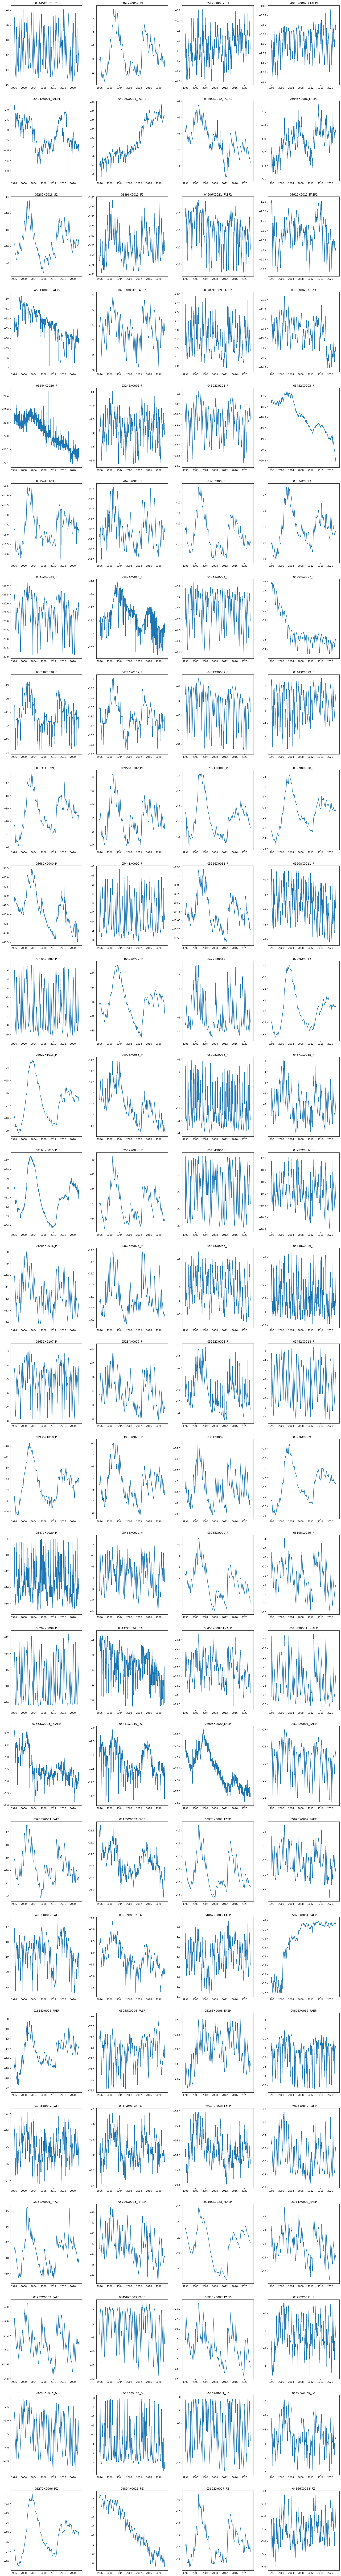

In [111]:
if data_interpol.shape[1]%4 == 0:
    nbre_lignes = data_interpol.shape[1]//4
else : 
    nbre_lignes = data_interpol.shape[1]//4 + 1

fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
#fig.suptitle('Series')
for i in range(nbre_lignes):
    for j in range(4):
        if i*4+j+1>data_interpol.shape[1]: # pass the others that we can't fill
            continue
        axs[i, j].plot(data_interpol.iloc[:,i*4+j])
        axs[i, j].set_title(data_interpol.columns[i*4+j])
plt.show()

## Normalisation StandardScaler

Comme il n'y a visuellement pas de valeurs abbérantes qui sautent aux yeux, la normalisation choisie est la standardisation

In [112]:
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df

In [113]:
scaler = StandardScaler()
data_norm = scaleColumns(data_interpol.copy())

In [114]:
data_norm.head()

05445X0081_P1  03627X0052_P1  05475X0057_P1  04915X0009_F1AEP1  \
date_mesure                                                                   
1995-11-29       -1.010092      -0.318346      -0.779842          -1.650320   
1995-12-06       -0.944607      -0.326203      -0.605646          -1.596020   
1995-12-13       -0.890922      -0.334059      -0.545820          -1.465204   
1995-12-20       -0.371179      -0.341916       0.070026          -1.191233   
1995-12-27        1.317248      -0.353701       0.619008          -0.954284   

             05421X0001_FAEP1  04286X0001_FAEP1  04265X0012_FAEP1  \
date_mesure                                                         
1995-11-29           1.895828         -1.341009          0.569806   
1995-12-06           1.878920         -1.293722          0.540530   
1995-12-13           1.974613         -1.273661          0.532546   
1995-12-20           1.992241         -1.239988          0.589322   
1995-12-27           2.029654         -1.239271          0.591097   

             05943X0006_FAEP1  03287X0018_S1  02896X0013_F2  ...  \
date_mesure                                                  ...   
1995-11-29          -1.946878       0.051814      -0.968304  ...   
1995-12-06          -1.997128       0.018089      -1.028344  ...   
1995-12-13          -1.826279       0.002464      -0.971276  ...   
1995-12-20          -1.407532       0.001683      -0.696636  ...   
1995-12-27          -1.058177      -0.030037      -0.709477  ...   

             05914X0007_PAEP  03252X0011_S  03248X0015_S  05446X0136_S  \
date_mesure                                                              
1995-11-29          0.495069     -2.276427     -0.871091     -0.384164   
1995-12-06          0.442116     -2.292501     -0.920475     -0.402722   
1995-12-13          0.396486     -2.247091     -0.909739     -0.443692   
1995-12-20          0.380450     -2.069872     -0.661283      0.141880   
1995-12-27          0.429347     -1.912344     -0.375635      1.560842   

             05465X0001_PZ  04597X0065_PZ  03272X0006_PZ  04894X0016_PZ  \
date_mesure                                                               
1995-11-29       -1.108546      -0.085607      -1.038503       1.465269   
1995-12-06       -1.069159      -0.117972      -1.025543       1.482832   
1995-12-13       -0.775697      -0.119934      -1.005023       1.503167   
1995-12-20        0.038438      -0.035587      -0.981444       1.542605   
1995-12-27        0.978701       0.045164      -0.973344       1.582167   

             03622X0027_PZ  04866X0038_PZ  
date_mesure                                
1995-11-29       -0.131546      -1.709007  
1995-12-06       -0.149635      -1.489200  
1995-12-13       -0.158077      -1.360599  
1995-12-20       -0.150358      -1.043748  
1995-12-27       -0.158679      -0.649189  

[5 rows x 108 columns]

## Sauvegarde du dataframe en csv

In [118]:
data_norm.to_csv(f"./data/piezo_clustering/{region}.csv", sep = ";")